# imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython.display import clear_output

import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

import numpy as np

from copy import deepcopy

## Домашнее задание 1. Обучение LeNet

На прошлой лабораторной мы рассмотрели пример обучения небольшой нейронной сети для классификации датасета CIFAR-10. В качестве домашнего задания вам предлагается классификация предметов одежды из датасета [**Fashion MNIST**](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST). Вы можете начать с имплементации классической сверточной сети [LeNet](https://en.wikipedia.org/wiki/LeNet) и улучшить ее методами, которые мы обсудили на лекции (dropout, batchnorm, etc).

### Загрузка датасета

In [ ]:
# Гиперпараметры
BATCH_SIZE = 128
torch.manual_seed(42);

In [3]:
# Загрузка FashionMNIST
transform_train = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)

transform_test = transforms.Compose([
    transforms.ToTensor()
])
test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    transform=transform_test
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

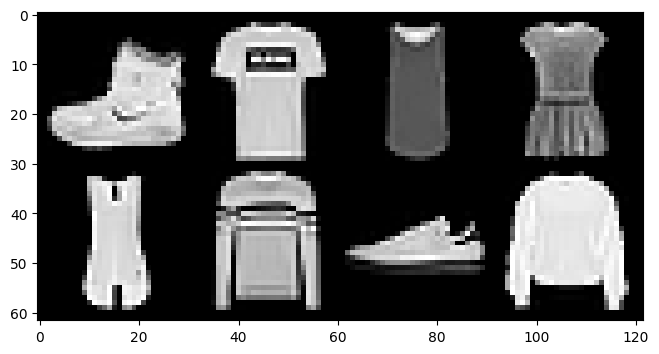

In [4]:
# Показать примеры картинок из датасета
grid = make_grid([train_loader.dataset[i][0] for i in range(8)], nrow=4)
plt.figure(figsize=(15, 4))
plt.imshow(grid.permute(1, 2, 0));

## Архитектура LeNet



### **Задание 1**: закончите имплементацию LeNet согласно диаграме сверху

In [5]:
class BadLeNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),   # [28x28x6]
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),       # [14x14x6]
            nn.Conv2d(6, 16, kernel_size=5),             # [10x10x16]
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2)        # [5x5x16]
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(5*5*16, 120),                      # [120]
            nn.Sigmoid(),
            nn.Linear(120, 84),                          # [84]
            nn.Sigmoid(),
            nn.Linear(84, 10)                            # [10]
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)        # [400]  
        x = self.fc_layers(x)
        x = F.log_softmax(x, dim=1)        
        return x

### **Задание 2**: Напишите функцию обучения

Вы можете воспользоваться кодом из прошлой лабораторной работы

Посчитайте точность на валидационном сете. 

In [6]:
class LearningModel():
    def __init__(self, model, train_loader, test_loader, device='auto'):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device

        # Определение устройства
        if device == 'auto':
            self.device_for_learning = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        elif device == 'cpu':
            self.device_for_learning = torch.device("cpu")
        elif device == 'cuda':
            self.device_for_learning = torch.device("cuda")
        else:
            raise ValueError("Invalid device choice. Use 'auto', 'cpu', or 'cuda'.")

    def plot_metrics(self) -> None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        train_loss, test_loss, train_acc, test_acc = self.metrics.values()

        axes[0].set_title(f'Train loss: {train_loss[-1]:.2f}, Test loss: {test_loss[-1]:.2f}')
        axes[0].plot(train_loss, label='Train_loss')
        axes[0].plot(test_loss, label='Test_loss')

        axes[1].set_title(f'Train acc: {train_acc[-1]:.2f}, Test acc: {test_acc[-1]:.2f}')
        axes[1].plot(train_acc, label='Train_acc')
        axes[1].plot(test_acc, label='Test_acc')

        legend = [ax.legend() for ax in axes]
        
        plt.show()

    def learning_function(self, epochs=10, learning_rate=0.001):
        
        self.metrics = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}
        

        self.model.to(self.device_for_learning)

        loss_func = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)  # Не знаем что взять - пробуем Adam
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Планировщик скорости обучения

        # Цикл обучения
        for epoch in range(epochs):
            loss_epoch, acc_epoch = 0, 0
            len_dataset = len(self.train_loader.dataset)
            
            for data, target in self.train_loader: #tqdm_notebook(train_loader, desc='Train', leave=False): 
                #print(data.shape, target.shape)
                # переместить данные и таргеты на устройство для обучения
                data, target = data.to(self.device_for_learning), target.to(self.device_for_learning)

                # пропустить данные через модель и посчитать ошибку
                logits = self.model(data)
                loss = loss_func(logits, target)

                # обучение сети
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # так как ошибка усредняется по батчу, делаем обратную денормировку
                # чтобы потом просто разделить на длину датасета
                loss_epoch += loss.item() * target.size(0)
                acc_epoch += torch.sum(logits.argmax(dim=1) == target).item()        

            self.metrics['train_loss'].append(loss_epoch / len_dataset)
            self.metrics['train_acc'].append(acc_epoch / len_dataset)
            
            # Валидация
            loss_epoch, acc_epoch  = 0, 0
            len_dataset = len(self.test_loader.dataset)        
            with torch.inference_mode():
                for data, target in self.test_loader: #tqdm_notebook(test_loader, desc='Validation', leave=False): 
                    # переместить данные и таргеты на устройство для обучения
                    data, target = data.to(self.device_for_learning), target.to(self.device_for_learning)

                    # пропустить данные через модель и посчитать ошибку
                    logits = self.model(data)
                    loss = loss_func(logits, target)


                    loss_epoch += loss.item() * target.size(0)
                    acc_epoch += torch.sum(logits.argmax(dim=1) == target).item()

            self.metrics['test_loss'].append(loss_epoch / len_dataset)
            self.metrics['test_acc'].append(acc_epoch / len_dataset)

            # отрисовка графиков
            clear_output(True)
            self.plot_metrics()


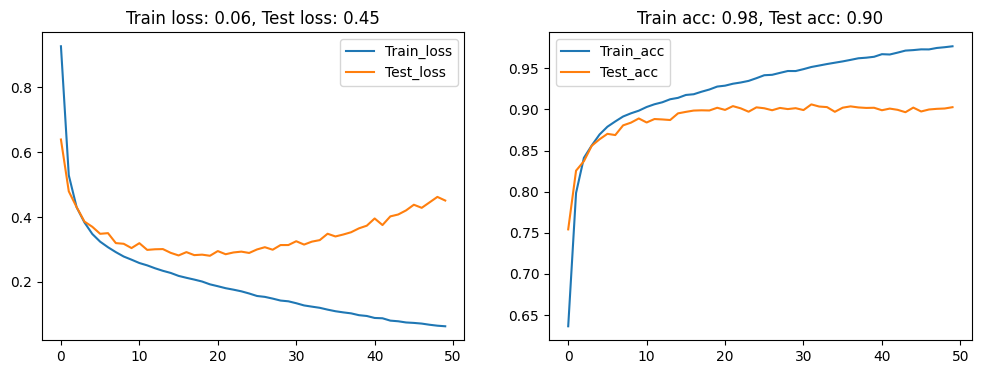

In [8]:
bad_lm = LearningModel(BadLeNet(), train_loader, test_loader, device='auto')
bad_lm.learning_function(epochs=50, learning_rate=0.005)

### **Задание 3**: Улучшите обучение продвинутыми методами

Вы можете добавить
- Dropout;
- BatchNorm;
- Data augmentation;
- Больше сверток к сети;
- Функции активации (ReLU, tahn, etc);
- Adam optimizer вместе с LR scheduler

In [9]:
class FashionLeNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),   # [28x28x6]
            #nn.BatchNorm2d(6),  # Для 2D данных
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),       # [14x14x6]
            nn.Conv2d(6, 16, kernel_size=5),             # [10x10x16]
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),        # [5x5x16]
            #nn.BatchNorm2d(400),  # Для 2D данных
            nn.Dropout(p=0.5)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(5*5*16, 120),                      # [120]
            nn.BatchNorm1d(120),  # Для 1D данных
            nn.ReLU(),
            nn.Linear(120, 84),                          # [84]
            #nn.BatchNorm1d(84),  # Для 1D данных
            nn.ReLU(),
            nn.Linear(84, 10)                            # [10]
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)        # [400]  
        x = self.fc_layers(x)
        x = F.log_softmax(x, dim=1)        
        return x

In [12]:
# Загрузка FashionMNIST
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Случайное отражение
    transforms.RandomRotation(15),      # Поворот ±15 градусов
    transforms.ColorJitter(brightness=0.2),  # Изменение яркости
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))  # Статистика FashionMNIST    
])
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))  # Статистика FashionMNIST    
])
test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    transform=transform_test
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

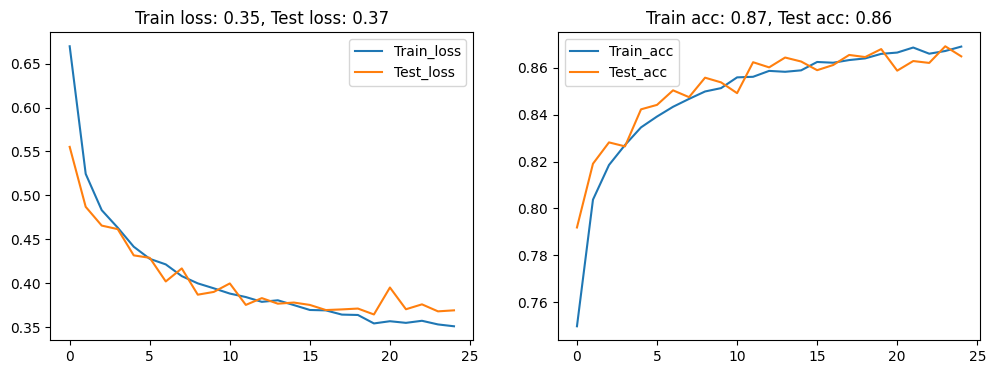

In [13]:
fashion_lm = LearningModel(FashionLeNet(), train_loader, test_loader, device='auto')
fashion_lm.learning_function(epochs=25, learning_rate=0.005)